In [10]:
import numpy as np
from scipy import fft as fft
from scipy.sparse.linalg import LinearOperator
from scipy.linalg import solve
from matplotlib import pyplot as plt
from functools import partial  

plt.rcParams['figure.figsize'] = [8, 4]
plt.rcParams['figure.dpi'] = 200 # 200 e.g. is really fine, but slower
plt.rcParams['axes.facecolor'] = 'black'
plt.rcParams['figure.facecolor'] = 'black'
plt.rcParams['text.color'] = 'white'
TRANSFORM= 'dct'

class Operator(LinearOperator):
    def __init__(self, N=500, L=1):
        self.L = L
        self.N = N
        self.shape = (N,N)
        self.x = np.linspace(0, self.L, num=self.N, endpoint=False)
        
    def norm(self, v):
        return np.sqrt(np.dot(v.conjugate(), v)*self.L/self.N)
    
class FourierMultiplier(Operator):

    def __init__(self, transform=TRANSFORM, **kwargs):
        super().__init__(**kwargs)
        self.dtype = None
        self.freqs = fft.fftfreq(self.N, d=self.L/self.N)
        self.multiplier = None ## Need to implement this on particular case
        self.transform = transform
        if self.transform == 'dct':
            self.to_freq_domain = partial(fft.dct, norm='ortho')
            self.to_time_domain = partial(fft.idct, norm='ortho')
            self.func = np.cos
        elif self.transform == 'dst':
            self.fwd = fft.dst
            self.inv = fft.idst
            self.func = np.sin
        elif self.transform == 'fft':
            self.to_freq_domain = partial(fft.fft, norm='ortho')
            self.to_time_domain = partial(fft.ifft, norm='ortho')
            self.func = lambda x: np.exp(2j*x)
         
    def eigenfunction(self, i):
        return lambda x: self.func(np.pi*self.freqs[i]*x)
        
    def eigenvector(self, i):
        v = self.eigenfunction(i)(self.x)
        return v / self.norm(v)

    def coeff2u(self, coeff):
        res = sum(coeff[i]*self.eigenfunction(i)(self.x) for i in np.where(np.abs(coeff) > 1e-5)[0])
        return res    
    
    def mult2time(self, mult):
        '''mult is assumed 2D!!!'''
        assert len(mult.shape) == 2
        # M4 = ifft(mult, axis=0)
        # M4 = ifft(M4.H, axis=0)
        M = self.to_time_domain(mult, axis=0)
        M = self.to_time_domain(M.conjugate().T, axis=0)
        return M
    
    def _matvec(self, v):
        return self(np.squeeze(v))
    
    def __call__(self, v, mult=None):
        if mult is None:
            mult = self.multiplier
        v_hat = self.to_freq_domain(v)
        Av_hat = v_hat * mult
        Av = self.to_time_domain(Av_hat) 
        return Av + np.mean(v)
    
#     @property
#     def matrix(self):
#         M = np.diag(self.multiplier) if len(self.multiplier.shape) == 1 else self.multiplier
#         M = self.inv(M)
#         M = M.conjugate().T
#         M = self.inv(M).conjugate().T
#         return M
        
    def __repr__(self):
        return str(self)
    
    def __str__(self):
        return 'Generic Fourier multiplier'
    
## Forward Operator
class Heat(FourierMultiplier):
    def __init__(self, time, alpha=1, **kwargs):
        super().__init__(**kwargs)
        self.alpha = alpha
        self.time = time
        self.multiplier = np.exp(-self.alpha * np.pi**2 * self.time * self.freqs**2)
          
    def __str__(self):
        return f'Heat operator alpha {alpha} time {time}'

    
class Prior(FourierMultiplier): ## Actually, negative Laplacian
    def __init__(self, gamma, **kwargs):
        assert gamma < 0
        super().__init__(**kwargs)
        ind = self.freqs != 0
        multiplier = np.ones(self.freqs.shape)
        multiplier[ind] = np.power(np.pi**2 * self.freqs[ind]**2, gamma)
        inv_mult = np.ones(self.freqs.shape)
        #(multiplier < 1e-4) #| (inv_mult < 1e-4) #| np.isnan(multiplier) | np.isnan(inv_mult) | (multiplier > 1e4) | (inv_mult > 1e4)
        inv_mult[ind] = np.power(np.pi**2 * self.freqs[ind]**2, -gamma)
        #ind[0] = True
        #ind[-1] = True
        #multiplier[ind] = 0
        self.multiplier = multiplier
        #inv_mult[ind] = 0
        self.inv_mult = inv_mult
        self.gamma = gamma
        #self.kwargs = kwargs
        #self.ind = ind
        #self.ind = ind
    
    def sample(self, return_coeffs=False):
        if self.transform == 'fft':
            coeffs = np.random.randn(self.N, 2).view(np.complex128) 
            coeffs = np.squeeze(coeffs)
        else:
            coeffs = np.random.randn(self.freqs.size)
        coeffs *= self.multiplier
        coeffs[0] = 0
        
        u0 = self.coeff2u(coeffs) 
        return u0, coeffs if return_coeffs else u0
        
    def inverse(self,v):
        return self(v, mult=self.inv_mult)
#         return Laplacian(gamma=-self.gamma, N=self.N, L=self.L)
    
    def __str__(self):
        return '$(-\Delta)^{' + str(self.gamma) + '}$'
    
    @property
    def invstr(self):
        return '$(-\Delta)^{' + str(-self.gamma) + '}$'    
    

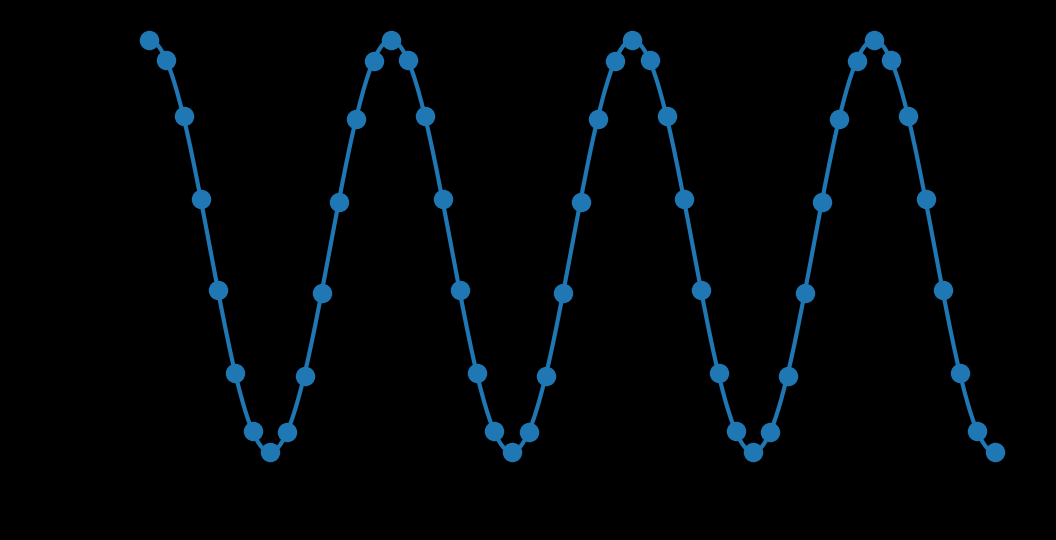

In [26]:
class PointObservation(FourierMultiplier):
    def __init__(self, meas=[], **kwargs):
        super().__init__(**kwargs)
        self.meas = np.array(meas)
        self.size = len(meas)
        self.multiplier = np.zeros((self.size, self.N), dtype=np.complex128)
        if self.transform == 'fft':
            for k in range(self.N):
                self.multiplier[:,k] = self.eigenfunction(k)(self.meas)/np.sqrt(self.N)
        elif self.transform == 'dct':
            for k in range(self.N):
                self.multiplier[:,k] = self.eigenfunction(k)(self.meas)/np.sqrt(0.5*self.N)
            
    def __call__(self, v):
        vhat = self.to_freq_domain(v)
        return np.einsum('ij, j -> i', self.multiplier, vhat)
                
        
class DiagObservation(FourierMultiplier):
    def __init__(self, singular_values, random_U=False, **kwargs):
        super().__init__(**kwargs)
        singular_values = np.array(singular_values)
        assert len(singular_values.shape) == 1
        self.multiplier = np.zeros((singular_values.shape[0], self.N))
        np.fill_diagonal(self.multiplier, singular_values)
        if random_U:
            H = np.random.randn(singular_values.shape[0], singular_values.shape[0])
            Q, R = np.linalg.qr(H) # From https://stackoverflow.com/questions/38426349/how-to-create-random-orthonormal-matrix-in-python-numpy
            Q = np.vdot(Q, np.diag(np.sign(np.diag(R))))
            self.multiplier = np.dot(Q, self.multiplier)
        O = self.to_time_domain(self.multiplier)
        Ostar = O.T.conj()
        self.OstarO = np.dot(Ostar, O)

k = 7
obs = PointObservation(N=1400, L=2, meas=np.linspace(0,2,50))
u = obs.eigenvector(k)

fig = plt.figure(figsize=(6,3))
plt.plot(obs.x, u)
plt.scatter(obs.meas, obs(u).real)
plt.show()

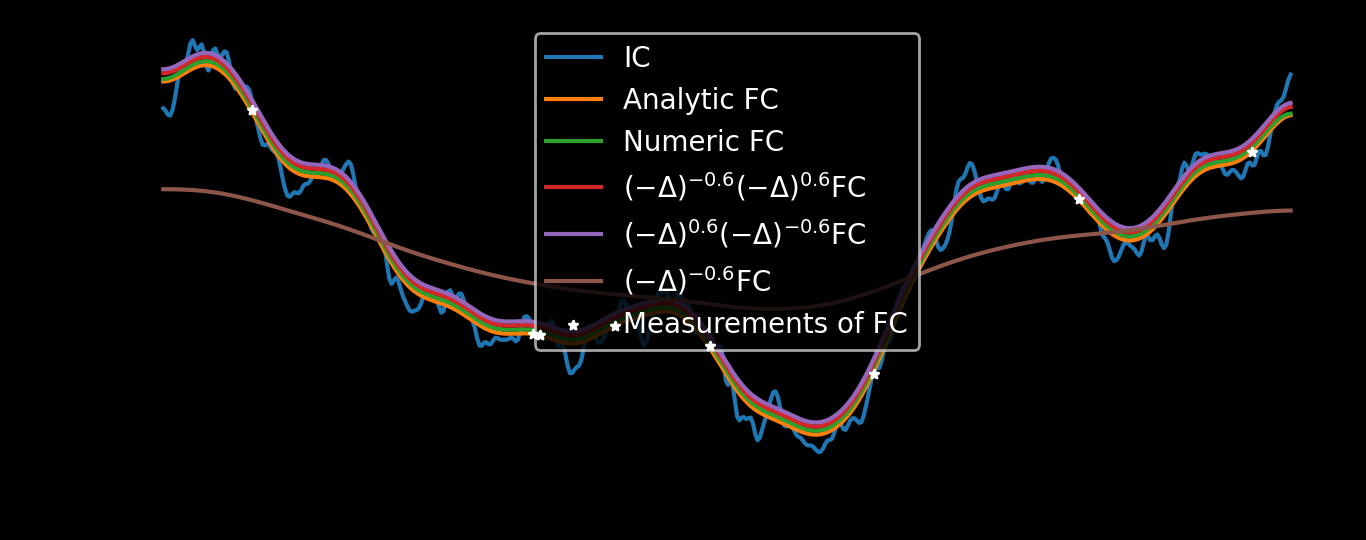

In [30]:
np.random.seed(5842)
N = 500
L = 3
time = 3e-3
alpha = 0.6
gamma = -.6

fwd = Heat(N=N, L=L, alpha=alpha, time=time)
prior = Prior(gamma=gamma, N=N, L=L)
obs = PointObservation(meas=[0.2356323, 0.9822345, 1.451242, 1.886632215, 2.43244, 2.89235633, 1, 1.2], L=L, N=N)

# IC
u0, coeffs0 = prior.sample(return_coeffs=True)

# Analytic
coeffsT = coeffs0 * fwd.multiplier
uT = prior.coeff2u(coeffsT)

# Numeric solution
uT_num = fwd(u0)

fig = plt.figure(figsize=(8,3))
plt.plot(fwd.x, u0.real, label='IC')
plt.plot(fwd.x, uT.real, label='Analytic FC')
plt.plot(fwd.x, uT_num.real+0.025, label='Numeric FC')
plt.plot(prior.x, prior(prior.inverse(uT)).real+0.05, label=str(prior) + prior.invstr + 'FC')
plt.plot(prior.x, prior.inverse(prior(uT)).real+0.075, label=prior.invstr + str(prior) + 'FC')
plt.plot(prior.x, prior(uT).real, label= str(prior) + 'FC')
#plt.plot(prior.x, prior.inverse(uT), label= prior.inv_str + 'FC')
plt.scatter(obs.meas, obs(uT).real, label='Measurements of FC', marker='*', s =10, color='w', zorder=10)

plt.legend()
    
#plt.close()

/home/yair/.local/lib/python3.8/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


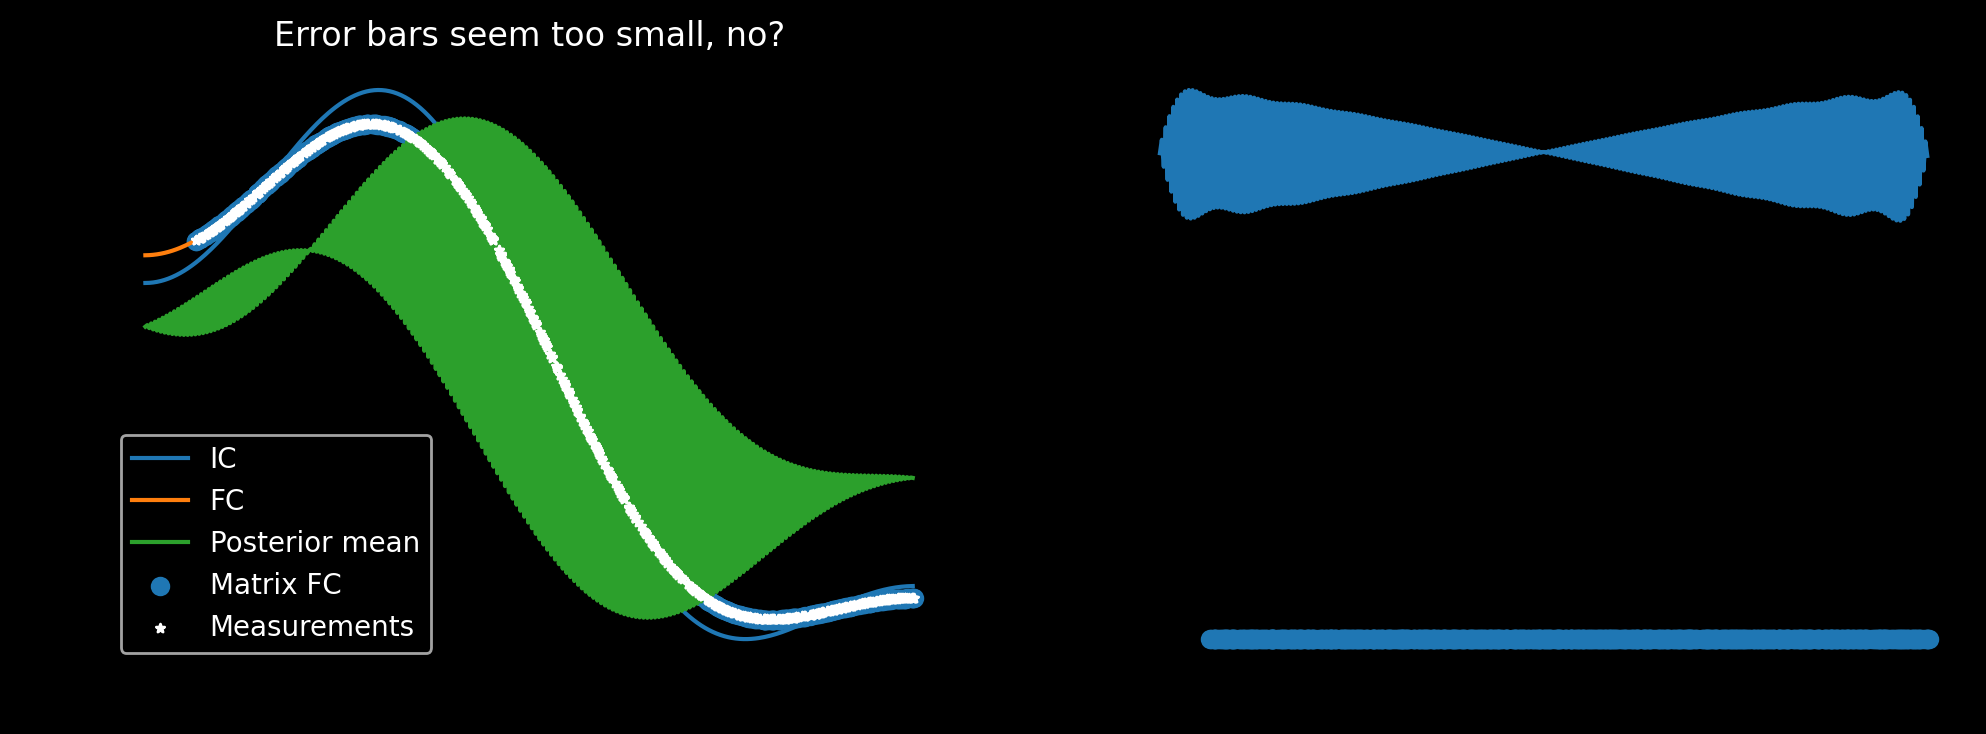

In [82]:
class Posterior(FourierMultiplier):
    ''' Based on Stuart 2.16a and 2.16b'''
    def __init__(self, fwd, prior, sigSqr, **kwargs):
        super().__init__(**kwargs)
        self.fwd = fwd
        self.prior = prior
        self.sigSqr = sigSqr
        
    def update(self, obs, data):
        self.A = np.einsum('ij,j->ij', obs.multiplier, self.fwd.multiplier)
        self.A_H = self.A.T if self.transform == 'dct' else self.A.conjugate().T
        self.AstarA = np.einsum('ij, jk-> ik', self.A_H, self.A)
        self.precision = self.AstarA/self.sigSqr + np.diag(self.prior.inv_mult)
        Sigma = np.linalg.inv(self.precision)
        
#         self.A = A
#         self.Sigma = Sigma
#         self.precision = precision
#         self.obs = obs
#         self.AstarA = AstarA
        self.Astar_data = np.einsum('ij, j->i', self.A_H, data)
        #Astar_data = self.to_freq_domain(Astar_data)
        #print(np.linalg.cond(Sigma))
        mean = solve(self.precision,  self.Astar_data, assume_a='her')/self.sigSqr
        #mean[80:] = 0

        self.m = self.to_time_domain(mean)
        self.ptwise = np.sqrt(np.abs(np.diag(self.mult2time(Sigma)))).real
        
    def utility(self, meas):
        obs = PointObservation(meas=meas, N=self.N, L=self.L)
        A = np.einsum('ij,j->ij', obs.multiplier, self.fwd.multiplier)
        AstarA = np.einsum('ji, jk->ik',A.conjugate(), A)
        C_sqrt = np.sqrt(self.prior.multiplier)
        tmp = np.einsum('i,ij,j->ij', C_sqrt, AstarA, C_sqrt.conjugate())/self.sigSqr + np.eye(self.N)
        utility = -np.linalg.slogdet(tmp)[1]
        assert utility < 0
        return {'meas':meas, 'utility': utility}
    
        
    def __le__(self, other):
        return self.utility <= other.utility
    
np.random.seed(134567)  
sig = 0.0005
N = 400
time = 5e-2

meas = np.linspace(0,L-0.2,endpoint=False, num=700)+0.2
meas += np.random.normal(scale=0.01, size=meas.size)
obs = PointObservation(meas=meas, L=L, N=N)
fwd = Heat(N=N, L=L, alpha=alpha, time=time)
prior = Prior(gamma=gamma, N=N, L=L)
prior.multiplier[4:] = 0
post = Posterior(fwd=fwd, prior=prior, sigSqr=sig**2, L=L, N=N)
u0 = prior.sample(return_coeffs=False)[0]
uT = fwd(u0)
data = obs(uT)# + np.random.normal(scale=sig, size=obs.size)
post.update(obs, data)


fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,4))
ax[0].plot(fwd.x, u0.real, label='IC')
ax[0].plot(fwd.x, uT.real, label='FC')
ax[0].scatter(obs.meas, np.dot(post.A, post.to_freq_domain(u0)).real, label='Matrix FC')
ax[0].scatter(obs.meas, data.real, label='Measurements', marker='*', s=10, color='w', zorder=10)
line, = ax[0].plot(post.x, post.m, label='Posterior mean')
#ax[0].plot(post.x, post.m + 2*post.ptwise, color=line.get_color(), label='Posterior std', linestyle=':')
#ax[0].plot(post.x, post.m - 2*post.ptwise, color=line.get_color(), linestyle=':')
ax[0].legend()
ax[0].set_title("Error bars seem too small, no?")

ax[1].plot(post.x, post.ptwise.real,label='posterior STD')
ax[1].scatter(obs.meas, np.zeros(obs.size), label='measurements')
#print(np.diag(post.Sigma)[:9])
#tra = post.to_freq_domain(post.m)
#plt.close()
#plt.plot(tra)

True

In [65]:
## Show DCT is orthogonal matrix
I = np.eye(fwd.N)
DCT = fwd.to_freq_domain(I)
print(np.max(np.abs(np.dot(DCT, DCT.T) - I)))

iDCT = fwd.to_time_domain(I)
print(np.max(np.abs(np.dot(iDCT, iDCT.T) - I)))

print(np.max(np.abs(np.dot(iDCT, DCT) - I)))
print(np.max(np.abs(np.dot(DCT, iDCT) - I)))

# for i in range(4):
#     ev1 = DCT[:,i]
#     #ev1 = ev1/ev1[0]
#     plt.plot(ev1, color='r')
#     ev2 = fwd.eigenvector(i)
#     #ev2 = ev2/ev2[0]
#     plt.plot(ev2+0.01, color='b')
#     #print(fwd.N, 1/(ev1/ev2))

8.881784197001252e-16
2.6645352591003757e-15
2.6645352591003757e-15
8.881784197001252e-16


/home/yair/.local/lib/python3.8/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/yair/.local/lib/python3.8/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


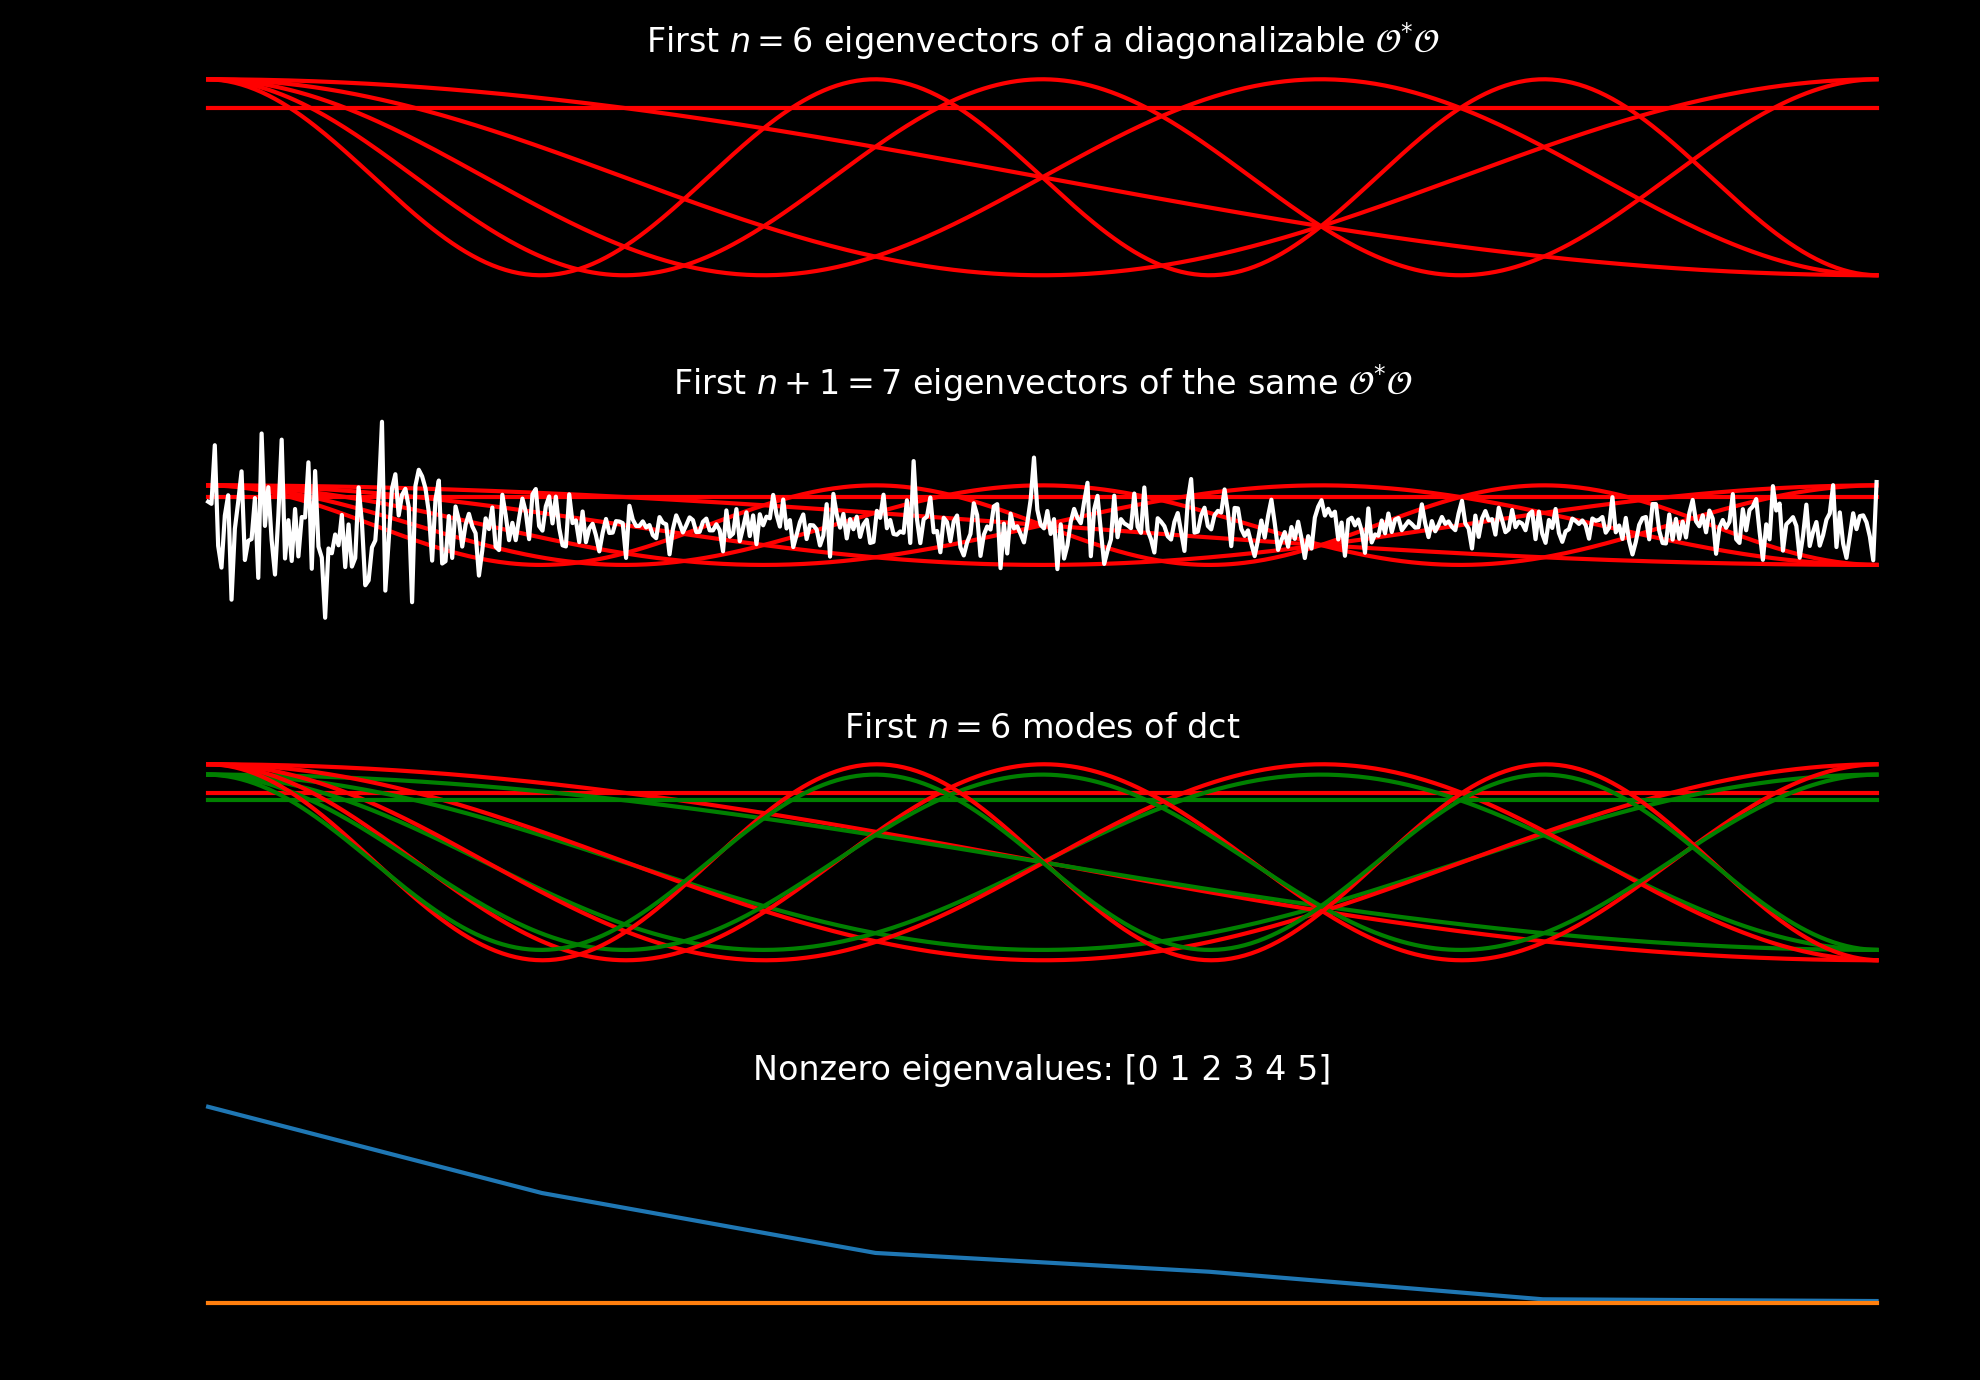

In [86]:
n = 6
singular_values = np.random.randn(n)**2
#singular_values[1] = 0
obs = DiagObservation(singular_values=singular_values,
                      N=500, 
                      random_U=True,
                      transform='dct')
D, P = np.linalg.eig(obs.OstarO)
P = np.einsum('ij, j -> ij', P, np.sign(P[0,:]))
fig, ax = plt.subplots(nrows=4, ncols=1, figsize=(10,7))
for i in range(n):
    ax[0].plot(obs.x, P[:,i].real, label=i, color='r')
    ax[1].plot(obs.x, P[:,i].real, label=i, color='r')
    ax[2].plot(obs.x, obs.eigenvector(i), label=f'True {i}', color='r')
    ax[2].plot(obs.x, 20*P[:,i].real, color='g')
ax[1].plot(obs.x, P[:,i+1], label='$n+1$', color='w')


# for axi in ax:
#     axi.legend(bbox_to_anchor=(1.05, 1), loc='upper left',
#              ncol=1, fancybox=True, shadow=True)


OstarO = "$\mathcal{O}^{*}\mathcal{O}$"
ax[0].set_title(f"First $n={n}$ eigenvectors of a diagonalizable " + OstarO)
ax[1].set_title(f"First $n+1={n+1}$ eigenvectors of the same "  +OstarO)
ax[2].set_title(f"First $n={n}$ modes of {obs.transform}")


ind = np.where(np.abs(D) > 1e-9)[0]
ax[3].plot(np.arange(n), D[:n], label='$\mathbf{e}_i$')
ax[3].plot(np.arange(n), np.zeros(n), label='y=0')
ax[3].set_title(f"Nonzero eigenvalues: {ind}")

plt.tight_layout()

Process ForkPoolWorker-13:
Process ForkPoolWorker-14:
Process ForkPoolWorker-12:
Process ForkPoolWorker-10:
Process ForkPoolWorker-11:
Process ForkPoolWorker-8:
Process ForkPoolWorker-15:
Traceback (most recent call last):
  File "/usr/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/usr/lib/python3.8/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):
  File "/usr/lib/python3.8/multiprocessing/pool.py", line 114, in worker
    task = get()
Traceback (most recent call last):
  File "/usr/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/usr/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/usr/lib/python3.8/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
Traceback (most recent c

KeyboardInterrupt: 